## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [3]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [4]:
## Import Keras objects for Deep Learning
import tensorflow as tf
from tensorflow import keras

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [5]:
## Load in the data set (remember to download diabetes.csv )
diabetes_df = pd.read_csv("diabetes.csv")

In [6]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
477,7,114,76,17,110,23.8,0.466,31,0
82,7,83,78,26,71,29.3,0.767,36,0
464,10,115,98,0,0,24.0,1.022,34,0
250,9,106,52,0,0,31.2,0.380,42,0
249,1,111,86,19,0,30.1,0.143,23,0


In [7]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["Outcome"].values

In [8]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [9]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [10]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.781
roc-auc is 0.829


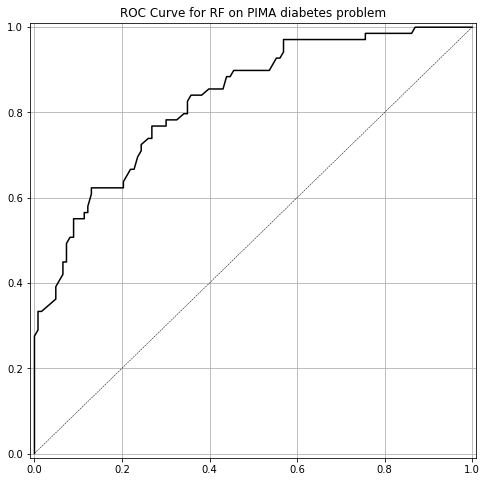

In [12]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [13]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [14]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, relu activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?

Yes, since there is 96 connections (8 x 12) between the input layer and the hidden layer which also creates 12 new inputs for the next layer which equates to 108 params between the input and hidden layer. The hidden to output layer has 12 connections to each ther but also creates the final neuron which creates 13 params in total here. In total there should be 121 params.


Let's fit our model for 200 epochs.

In [27]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Train on 576 samples, validate on 192 samples
Epoch 1/200
576/576 [==============================] - 0s 209us/step - loss: 0.4184 - accuracy: 0.7986 - val_loss: 0.5178 - val_accuracy: 0.7500
Epoch 2/200
576/576 [==============================] - 0s 35us/step - loss: 0.4183 - accuracy: 0.7969 - val_loss: 0.5178 - val_accuracy: 0.7500
Epoch 3/200
576/576 [==============================] - 0s 35us/step - loss: 0.4183 - accuracy: 0.7951 - val_loss: 0.5178 - val_accuracy: 0.7500
Epoch 4/200
576/576 [==============================] - 0s 35us/step - loss: 0.4183 - accuracy: 0.7969 - val_loss: 0.5178 - val_accuracy: 0.7500
Epoch 5/200
576/576 [==============================] - 0s 35us/step - loss: 0.4183 - accuracy: 0.7986 - val_loss: 0.5179 - val_accuracy: 0.7500
Epoch 6/200
576/576 [==============================] - 0s 36us/step - loss: 0.4183 - accuracy: 0.7969 - val_loss: 0.5179 - val_accuracy: 0.7500
Epoch 7/200
576/576 [==============================] - 0s 40us/step - loss: 0.4183 - accu

576/576 [==============================] - 0s 33us/step - loss: 0.4161 - accuracy: 0.7969 - val_loss: 0.5202 - val_accuracy: 0.7500
Epoch 114/200
576/576 [==============================] - 0s 38us/step - loss: 0.4161 - accuracy: 0.7986 - val_loss: 0.5202 - val_accuracy: 0.7500
Epoch 115/200
576/576 [==============================] - 0s 35us/step - loss: 0.4161 - accuracy: 0.7986 - val_loss: 0.5202 - val_accuracy: 0.7500
Epoch 116/200
576/576 [==============================] - 0s 31us/step - loss: 0.4160 - accuracy: 0.7986 - val_loss: 0.5202 - val_accuracy: 0.7500
Epoch 117/200
576/576 [==============================] - 0s 31us/step - loss: 0.4160 - accuracy: 0.7969 - val_loss: 0.5202 - val_accuracy: 0.7500
Epoch 118/200
576/576 [==============================] - 0s 31us/step - loss: 0.4160 - accuracy: 0.7986 - val_loss: 0.5202 - val_accuracy: 0.7500
Epoch 119/200
576/576 [==============================] - 0s 33us/step - loss: 0.4159 - accuracy: 0.7969 - val_loss: 0.5202 - val_accuracy:

In [17]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [18]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]])

In [19]:
y_pred_prob_nn_1[:10]

array([[0.46299684],
       [0.79895157],
       [0.30744654],
       [0.28148106],
       [0.23271576],
       [0.5688626 ],
       [0.06217992],
       [0.32292894],
       [0.7935041 ],
       [0.140264  ]], dtype=float32)

accuracy is 0.745
roc-auc is 0.806


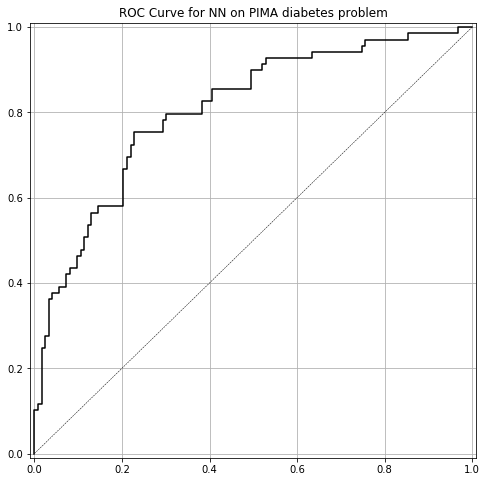

In [20]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [21]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

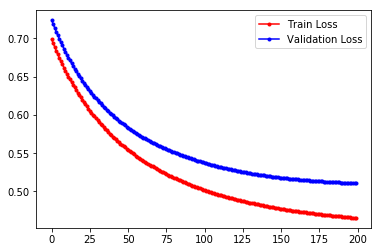

In [22]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [23]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 576 samples, validate on 192 samples
Epoch 1/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4653 - accuracy: 0.7726 - val_loss: 0.5105 - val_accuracy: 0.7448
Epoch 2/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4651 - accuracy: 0.7708 - val_loss: 0.5104 - val_accuracy: 0.7448
Epoch 3/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4649 - accuracy: 0.7708 - val_loss: 0.5103 - val_accuracy: 0.7448
Epoch 4/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4647 - accuracy: 0.7708 - val_loss: 0.5102 - val_accuracy: 0.7448
Epoch 5/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4646 - accuracy: 0.7708 - val_loss: 0.5101 - val_accuracy: 0.7448
Epoch 6/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4644 - accuracy: 0.7708 - val_loss: 0.5100 - val_accuracy: 0.7448
Epoch 7/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4642 

Epoch 57/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4575 - accuracy: 0.7778 - val_loss: 0.5069 - val_accuracy: 0.7604
Epoch 58/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4574 - accuracy: 0.7778 - val_loss: 0.5068 - val_accuracy: 0.7604
Epoch 59/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4573 - accuracy: 0.7778 - val_loss: 0.5068 - val_accuracy: 0.7604
Epoch 60/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4572 - accuracy: 0.7778 - val_loss: 0.5067 - val_accuracy: 0.7604
Epoch 61/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4571 - accuracy: 0.7778 - val_loss: 0.5067 - val_accuracy: 0.7604
Epoch 62/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4570 - accuracy: 0.7778 - val_loss: 0.5067 - val_accuracy: 0.7604
Epoch 63/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4569 - accuracy: 0.7778 - val_loss: 0.5066 -

576/576 [==============================] - 0s 29us/step - loss: 0.4525 - accuracy: 0.7847 - val_loss: 0.5047 - val_accuracy: 0.7604
Epoch 114/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4524 - accuracy: 0.7847 - val_loss: 0.5047 - val_accuracy: 0.7604
Epoch 115/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4523 - accuracy: 0.7830 - val_loss: 0.5047 - val_accuracy: 0.7604
Epoch 116/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4523 - accuracy: 0.7847 - val_loss: 0.5046 - val_accuracy: 0.7604
Epoch 117/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4522 - accuracy: 0.7830 - val_loss: 0.5046 - val_accuracy: 0.7604
Epoch 118/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4521 - accuracy: 0.7830 - val_loss: 0.5046 - val_accuracy: 0.7604
Epoch 119/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4520 - accuracy: 0.7830 - val_loss: 0.5046 - val_acc

Epoch 224/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4452 - accuracy: 0.7865 - val_loss: 0.5033 - val_accuracy: 0.7656
Epoch 225/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4451 - accuracy: 0.7865 - val_loss: 0.5033 - val_accuracy: 0.7656
Epoch 226/1000
576/576 [==============================] - 0s 28us/step - loss: 0.4450 - accuracy: 0.7865 - val_loss: 0.5034 - val_accuracy: 0.7656
Epoch 227/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4450 - accuracy: 0.7865 - val_loss: 0.5034 - val_accuracy: 0.7656
Epoch 228/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4449 - accuracy: 0.7865 - val_loss: 0.5034 - val_accuracy: 0.7656
Epoch 229/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4449 - accuracy: 0.7865 - val_loss: 0.5034 - val_accuracy: 0.7656
Epoch 230/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4448 - accuracy: 0.7865 - val_loss: 0

Epoch 280/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4421 - accuracy: 0.7847 - val_loss: 0.5042 - val_accuracy: 0.7604
Epoch 281/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4420 - accuracy: 0.7847 - val_loss: 0.5042 - val_accuracy: 0.7604
Epoch 282/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4420 - accuracy: 0.7830 - val_loss: 0.5042 - val_accuracy: 0.7604
Epoch 283/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4419 - accuracy: 0.7847 - val_loss: 0.5042 - val_accuracy: 0.7604
Epoch 284/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4418 - accuracy: 0.7830 - val_loss: 0.5043 - val_accuracy: 0.7604
Epoch 285/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4418 - accuracy: 0.7830 - val_loss: 0.5043 - val_accuracy: 0.7604
Epoch 286/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4417 - accuracy: 0.7830 - val_loss: 0

Epoch 336/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4395 - accuracy: 0.7882 - val_loss: 0.5053 - val_accuracy: 0.7448
Epoch 337/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4395 - accuracy: 0.7882 - val_loss: 0.5053 - val_accuracy: 0.7448
Epoch 338/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4394 - accuracy: 0.7882 - val_loss: 0.5053 - val_accuracy: 0.7448
Epoch 339/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4394 - accuracy: 0.7882 - val_loss: 0.5053 - val_accuracy: 0.7448
Epoch 340/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4393 - accuracy: 0.7865 - val_loss: 0.5053 - val_accuracy: 0.7448
Epoch 341/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4393 - accuracy: 0.7882 - val_loss: 0.5054 - val_accuracy: 0.7448
Epoch 342/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4392 - accuracy: 0.7882 - val_loss: 0

Epoch 392/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4371 - accuracy: 0.7865 - val_loss: 0.5065 - val_accuracy: 0.7448
Epoch 393/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4371 - accuracy: 0.7865 - val_loss: 0.5065 - val_accuracy: 0.7448
Epoch 394/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4370 - accuracy: 0.7865 - val_loss: 0.5065 - val_accuracy: 0.7448
Epoch 395/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4370 - accuracy: 0.7865 - val_loss: 0.5066 - val_accuracy: 0.7448
Epoch 396/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4369 - accuracy: 0.7865 - val_loss: 0.5066 - val_accuracy: 0.7448
Epoch 397/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4369 - accuracy: 0.7865 - val_loss: 0.5066 - val_accuracy: 0.7448
Epoch 398/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4368 - accuracy: 0.7865 - val_loss: 0

Epoch 448/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4347 - accuracy: 0.7899 - val_loss: 0.5076 - val_accuracy: 0.7448
Epoch 449/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4346 - accuracy: 0.7899 - val_loss: 0.5076 - val_accuracy: 0.7448
Epoch 450/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4346 - accuracy: 0.7882 - val_loss: 0.5076 - val_accuracy: 0.7448
Epoch 451/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4346 - accuracy: 0.7899 - val_loss: 0.5076 - val_accuracy: 0.7448
Epoch 452/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4345 - accuracy: 0.7882 - val_loss: 0.5077 - val_accuracy: 0.7448
Epoch 453/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4345 - accuracy: 0.7899 - val_loss: 0.5077 - val_accuracy: 0.7448
Epoch 454/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4345 - accuracy: 0.7899 - val_loss: 0

Epoch 504/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4327 - accuracy: 0.7899 - val_loss: 0.5087 - val_accuracy: 0.7448
Epoch 505/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4327 - accuracy: 0.7899 - val_loss: 0.5087 - val_accuracy: 0.7448
Epoch 506/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4326 - accuracy: 0.7882 - val_loss: 0.5088 - val_accuracy: 0.7448
Epoch 507/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4326 - accuracy: 0.7882 - val_loss: 0.5088 - val_accuracy: 0.7448
Epoch 508/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4326 - accuracy: 0.7899 - val_loss: 0.5088 - val_accuracy: 0.7448
Epoch 509/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4325 - accuracy: 0.7882 - val_loss: 0.5088 - val_accuracy: 0.7448
Epoch 510/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4325 - accuracy: 0.7899 - val_loss: 0

Epoch 560/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4309 - accuracy: 0.7882 - val_loss: 0.5097 - val_accuracy: 0.7396
Epoch 561/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4309 - accuracy: 0.7882 - val_loss: 0.5097 - val_accuracy: 0.7396
Epoch 562/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4308 - accuracy: 0.7882 - val_loss: 0.5097 - val_accuracy: 0.7396
Epoch 563/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4308 - accuracy: 0.7882 - val_loss: 0.5097 - val_accuracy: 0.7396
Epoch 564/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4307 - accuracy: 0.7882 - val_loss: 0.5097 - val_accuracy: 0.7396
Epoch 565/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4307 - accuracy: 0.7899 - val_loss: 0.5097 - val_accuracy: 0.7396
Epoch 566/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4307 - accuracy: 0.7899 - val_loss: 0

Epoch 616/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4291 - accuracy: 0.7899 - val_loss: 0.5105 - val_accuracy: 0.7396
Epoch 617/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4290 - accuracy: 0.7899 - val_loss: 0.5106 - val_accuracy: 0.7396
Epoch 618/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4290 - accuracy: 0.7899 - val_loss: 0.5106 - val_accuracy: 0.7396
Epoch 619/1000
576/576 [==============================] - 0s 29us/step - loss: 0.4290 - accuracy: 0.7899 - val_loss: 0.5106 - val_accuracy: 0.7396
Epoch 620/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4290 - accuracy: 0.7899 - val_loss: 0.5106 - val_accuracy: 0.7396
Epoch 621/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4289 - accuracy: 0.7899 - val_loss: 0.5106 - val_accuracy: 0.7396
Epoch 622/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4289 - accuracy: 0.7899 - val_loss: 0

Epoch 672/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4272 - accuracy: 0.7899 - val_loss: 0.5115 - val_accuracy: 0.7396
Epoch 673/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4271 - accuracy: 0.7899 - val_loss: 0.5115 - val_accuracy: 0.7396
Epoch 674/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4271 - accuracy: 0.7899 - val_loss: 0.5115 - val_accuracy: 0.7396
Epoch 675/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4271 - accuracy: 0.7899 - val_loss: 0.5116 - val_accuracy: 0.7396
Epoch 676/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4270 - accuracy: 0.7882 - val_loss: 0.5116 - val_accuracy: 0.7396
Epoch 677/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4270 - accuracy: 0.7899 - val_loss: 0.5116 - val_accuracy: 0.7396
Epoch 678/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4269 - accuracy: 0.7899 - val_loss: 0

Epoch 783/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4234 - accuracy: 0.7934 - val_loss: 0.5136 - val_accuracy: 0.7500
Epoch 784/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4234 - accuracy: 0.7934 - val_loss: 0.5136 - val_accuracy: 0.7500
Epoch 785/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4234 - accuracy: 0.7951 - val_loss: 0.5137 - val_accuracy: 0.7500
Epoch 786/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4234 - accuracy: 0.7951 - val_loss: 0.5137 - val_accuracy: 0.7500
Epoch 787/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4233 - accuracy: 0.7934 - val_loss: 0.5137 - val_accuracy: 0.7500
Epoch 788/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4233 - accuracy: 0.7951 - val_loss: 0.5137 - val_accuracy: 0.7500
Epoch 789/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4232 - accuracy: 0.7934 - val_loss: 0

Epoch 839/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4219 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7500
Epoch 840/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4218 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7500
Epoch 841/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4218 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7500
Epoch 842/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4218 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7500
Epoch 843/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4218 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7500
Epoch 844/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4218 - accuracy: 0.7951 - val_loss: 0.5150 - val_accuracy: 0.7500
Epoch 845/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4217 - accuracy: 0.7951 - val_loss: 0

Epoch 950/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4194 - accuracy: 0.7969 - val_loss: 0.5167 - val_accuracy: 0.7500
Epoch 951/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4194 - accuracy: 0.7969 - val_loss: 0.5167 - val_accuracy: 0.7500
Epoch 952/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4194 - accuracy: 0.7951 - val_loss: 0.5167 - val_accuracy: 0.7500
Epoch 953/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4193 - accuracy: 0.7951 - val_loss: 0.5168 - val_accuracy: 0.7500
Epoch 954/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4193 - accuracy: 0.7951 - val_loss: 0.5168 - val_accuracy: 0.7500
Epoch 955/1000
576/576 [==============================] - 0s 33us/step - loss: 0.4193 - accuracy: 0.7951 - val_loss: 0.5168 - val_accuracy: 0.7500
Epoch 956/1000
576/576 [==============================] - 0s 31us/step - loss: 0.4193 - accuracy: 0.7969 - val_loss: 0

In [ ]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise - Compulsary Task 2
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [25]:
# Type your code here to with layer 1,2 having activation relu and layer 3 with activation sigmoid

model_student = Sequential([
    Dense(6, input_shape=(8,), activation="relu"), # 8 input and 6 hidden nodes in first hidden layer
    Dense(6, activation="relu"), # 6 nodes of next hidden layer
    Dense(1, activation="sigmoid") # final node and output layer
])

In [26]:
model_student.summary() # getting a bit of oversight of how the params change in the new model
# shows the params per layer level, which is the number of relationships from previous to next layers as well as counting the neurons in the layer receiving the inputs

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_student.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"]) # compiling the model and getting accuracy metrics
run_hist_student= model_student.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs = 1500)

Train on 576 samples, validate on 192 samples
Epoch 1/1500
576/576 [==============================] - 0s 268us/step - loss: 0.4066 - accuracy: 0.8125 - val_loss: 0.5202 - val_accuracy: 0.7604
Epoch 2/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4066 - accuracy: 0.8142 - val_loss: 0.5203 - val_accuracy: 0.7604
Epoch 3/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4066 - accuracy: 0.8177 - val_loss: 0.5202 - val_accuracy: 0.7604
Epoch 4/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4066 - accuracy: 0.8108 - val_loss: 0.5203 - val_accuracy: 0.7604
Epoch 5/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4067 - accuracy: 0.8125 - val_loss: 0.5203 - val_accuracy: 0.7604
Epoch 6/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4066 - accuracy: 0.8125 - val_loss: 0.5203 - val_accuracy: 0.7604
Epoch 7/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4067

Epoch 57/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4063 - accuracy: 0.8108 - val_loss: 0.5210 - val_accuracy: 0.7604
Epoch 58/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4063 - accuracy: 0.8125 - val_loss: 0.5210 - val_accuracy: 0.7552
Epoch 59/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4063 - accuracy: 0.8108 - val_loss: 0.5211 - val_accuracy: 0.7552
Epoch 60/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4063 - accuracy: 0.8160 - val_loss: 0.5210 - val_accuracy: 0.7552
Epoch 61/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4063 - accuracy: 0.8108 - val_loss: 0.5211 - val_accuracy: 0.7552
Epoch 62/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4062 - accuracy: 0.8125 - val_loss: 0.5211 - val_accuracy: 0.7552
Epoch 63/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4063 - accuracy: 0.8142 - val_loss: 0.5211 -

576/576 [==============================] - 0s 35us/step - loss: 0.4059 - accuracy: 0.8108 - val_loss: 0.5219 - val_accuracy: 0.7552
Epoch 114/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4059 - accuracy: 0.8142 - val_loss: 0.5219 - val_accuracy: 0.7552
Epoch 115/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4059 - accuracy: 0.8142 - val_loss: 0.5219 - val_accuracy: 0.7552
Epoch 116/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4059 - accuracy: 0.8125 - val_loss: 0.5219 - val_accuracy: 0.7552
Epoch 117/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4059 - accuracy: 0.8108 - val_loss: 0.5219 - val_accuracy: 0.7552
Epoch 118/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4059 - accuracy: 0.8125 - val_loss: 0.5219 - val_accuracy: 0.7552
Epoch 119/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4059 - accuracy: 0.8142 - val_loss: 0.5219 - val_acc

Epoch 169/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4056 - accuracy: 0.8108 - val_loss: 0.5227 - val_accuracy: 0.7552
Epoch 170/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4056 - accuracy: 0.8108 - val_loss: 0.5227 - val_accuracy: 0.7552
Epoch 171/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4056 - accuracy: 0.8125 - val_loss: 0.5228 - val_accuracy: 0.7552
Epoch 172/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4058 - accuracy: 0.8177 - val_loss: 0.5228 - val_accuracy: 0.7552
Epoch 173/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4056 - accuracy: 0.8125 - val_loss: 0.5228 - val_accuracy: 0.7552
Epoch 174/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4055 - accuracy: 0.8142 - val_loss: 0.5228 - val_accuracy: 0.7552
Epoch 175/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4056 - accuracy: 0.8142 - val_loss: 0

Epoch 225/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4053 - accuracy: 0.8142 - val_loss: 0.5234 - val_accuracy: 0.7604
Epoch 226/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4053 - accuracy: 0.8125 - val_loss: 0.5234 - val_accuracy: 0.7552
Epoch 227/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4053 - accuracy: 0.8108 - val_loss: 0.5234 - val_accuracy: 0.7604
Epoch 228/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4053 - accuracy: 0.8125 - val_loss: 0.5235 - val_accuracy: 0.7604
Epoch 229/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4052 - accuracy: 0.8108 - val_loss: 0.5235 - val_accuracy: 0.7604
Epoch 230/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4053 - accuracy: 0.8125 - val_loss: 0.5235 - val_accuracy: 0.7604
Epoch 231/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4052 - accuracy: 0.8125 - val_loss: 0

Epoch 281/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4051 - accuracy: 0.8160 - val_loss: 0.5242 - val_accuracy: 0.7552
Epoch 282/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4050 - accuracy: 0.8125 - val_loss: 0.5242 - val_accuracy: 0.7552
Epoch 283/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4049 - accuracy: 0.8142 - val_loss: 0.5242 - val_accuracy: 0.7552
Epoch 284/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4050 - accuracy: 0.8090 - val_loss: 0.5242 - val_accuracy: 0.7552
Epoch 285/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4050 - accuracy: 0.8108 - val_loss: 0.5242 - val_accuracy: 0.7552
Epoch 286/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4049 - accuracy: 0.8160 - val_loss: 0.5242 - val_accuracy: 0.7552
Epoch 287/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4051 - accuracy: 0.8142 - val_loss: 0

Epoch 337/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4047 - accuracy: 0.8160 - val_loss: 0.5248 - val_accuracy: 0.7552
Epoch 338/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4047 - accuracy: 0.8125 - val_loss: 0.5248 - val_accuracy: 0.7552
Epoch 339/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4047 - accuracy: 0.8125 - val_loss: 0.5248 - val_accuracy: 0.7552
Epoch 340/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4046 - accuracy: 0.8125 - val_loss: 0.5248 - val_accuracy: 0.7552
Epoch 341/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4048 - accuracy: 0.8125 - val_loss: 0.5249 - val_accuracy: 0.7552
Epoch 342/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4047 - accuracy: 0.8108 - val_loss: 0.5249 - val_accuracy: 0.7552
Epoch 343/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4046 - accuracy: 0.8125 - val_loss: 0

Epoch 393/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4045 - accuracy: 0.8090 - val_loss: 0.5255 - val_accuracy: 0.7552
Epoch 394/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4044 - accuracy: 0.8125 - val_loss: 0.5255 - val_accuracy: 0.7552
Epoch 395/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4043 - accuracy: 0.8125 - val_loss: 0.5255 - val_accuracy: 0.7552
Epoch 396/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4044 - accuracy: 0.8090 - val_loss: 0.5256 - val_accuracy: 0.7552
Epoch 397/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4044 - accuracy: 0.8108 - val_loss: 0.5256 - val_accuracy: 0.7552
Epoch 398/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4044 - accuracy: 0.8125 - val_loss: 0.5256 - val_accuracy: 0.7552
Epoch 399/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4044 - accuracy: 0.8108 - val_loss: 0

Epoch 449/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4041 - accuracy: 0.8090 - val_loss: 0.5261 - val_accuracy: 0.7500
Epoch 450/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4041 - accuracy: 0.8108 - val_loss: 0.5261 - val_accuracy: 0.7500
Epoch 451/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4041 - accuracy: 0.8090 - val_loss: 0.5261 - val_accuracy: 0.7500
Epoch 452/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4041 - accuracy: 0.8125 - val_loss: 0.5261 - val_accuracy: 0.7500
Epoch 453/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4041 - accuracy: 0.8125 - val_loss: 0.5262 - val_accuracy: 0.7500
Epoch 454/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4041 - accuracy: 0.8073 - val_loss: 0.5262 - val_accuracy: 0.7500
Epoch 455/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4040 - accuracy: 0.8108 - val_loss: 0

Epoch 505/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4038 - accuracy: 0.8108 - val_loss: 0.5268 - val_accuracy: 0.7500
Epoch 506/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4038 - accuracy: 0.8090 - val_loss: 0.5268 - val_accuracy: 0.7500
Epoch 507/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4038 - accuracy: 0.8125 - val_loss: 0.5267 - val_accuracy: 0.7500
Epoch 508/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4038 - accuracy: 0.8125 - val_loss: 0.5268 - val_accuracy: 0.7500
Epoch 509/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4038 - accuracy: 0.8108 - val_loss: 0.5268 - val_accuracy: 0.7500
Epoch 510/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4038 - accuracy: 0.8125 - val_loss: 0.5267 - val_accuracy: 0.7500
Epoch 511/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4038 - accuracy: 0.8090 - val_loss: 0

Epoch 561/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4035 - accuracy: 0.8125 - val_loss: 0.5273 - val_accuracy: 0.7448
Epoch 562/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4035 - accuracy: 0.8108 - val_loss: 0.5273 - val_accuracy: 0.7448
Epoch 563/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4035 - accuracy: 0.8108 - val_loss: 0.5273 - val_accuracy: 0.7448
Epoch 564/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4035 - accuracy: 0.8108 - val_loss: 0.5273 - val_accuracy: 0.7448
Epoch 565/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4035 - accuracy: 0.8090 - val_loss: 0.5273 - val_accuracy: 0.7448
Epoch 566/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4036 - accuracy: 0.8108 - val_loss: 0.5274 - val_accuracy: 0.7448
Epoch 567/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4036 - accuracy: 0.8090 - val_loss: 0

Epoch 617/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4031 - accuracy: 0.8090 - val_loss: 0.5280 - val_accuracy: 0.7448
Epoch 618/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4032 - accuracy: 0.8090 - val_loss: 0.5280 - val_accuracy: 0.7448
Epoch 619/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4032 - accuracy: 0.8090 - val_loss: 0.5280 - val_accuracy: 0.7448
Epoch 620/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4031 - accuracy: 0.8090 - val_loss: 0.5280 - val_accuracy: 0.7448
Epoch 621/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4032 - accuracy: 0.8090 - val_loss: 0.5280 - val_accuracy: 0.7448
Epoch 622/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4031 - accuracy: 0.8090 - val_loss: 0.5280 - val_accuracy: 0.7448
Epoch 623/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4031 - accuracy: 0.8090 - val_loss: 0

Epoch 673/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4029 - accuracy: 0.8090 - val_loss: 0.5284 - val_accuracy: 0.7448
Epoch 674/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4028 - accuracy: 0.8090 - val_loss: 0.5284 - val_accuracy: 0.7448
Epoch 675/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4029 - accuracy: 0.8090 - val_loss: 0.5284 - val_accuracy: 0.7448
Epoch 676/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4028 - accuracy: 0.8090 - val_loss: 0.5284 - val_accuracy: 0.7448
Epoch 677/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4028 - accuracy: 0.8108 - val_loss: 0.5284 - val_accuracy: 0.7448
Epoch 678/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4028 - accuracy: 0.8090 - val_loss: 0.5284 - val_accuracy: 0.7448
Epoch 679/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4029 - accuracy: 0.8090 - val_loss: 0

Epoch 729/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4025 - accuracy: 0.8090 - val_loss: 0.5287 - val_accuracy: 0.7448
Epoch 730/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4025 - accuracy: 0.8090 - val_loss: 0.5287 - val_accuracy: 0.7448
Epoch 731/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4026 - accuracy: 0.8090 - val_loss: 0.5287 - val_accuracy: 0.7448
Epoch 732/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4026 - accuracy: 0.8090 - val_loss: 0.5287 - val_accuracy: 0.7448
Epoch 733/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4025 - accuracy: 0.8090 - val_loss: 0.5287 - val_accuracy: 0.7448
Epoch 734/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4025 - accuracy: 0.8108 - val_loss: 0.5287 - val_accuracy: 0.7448
Epoch 735/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4025 - accuracy: 0.8073 - val_loss: 0

Epoch 785/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4022 - accuracy: 0.8073 - val_loss: 0.5291 - val_accuracy: 0.7448
Epoch 786/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4022 - accuracy: 0.8073 - val_loss: 0.5291 - val_accuracy: 0.7448
Epoch 787/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4022 - accuracy: 0.8073 - val_loss: 0.5292 - val_accuracy: 0.7448
Epoch 788/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4021 - accuracy: 0.8073 - val_loss: 0.5292 - val_accuracy: 0.7448
Epoch 789/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4021 - accuracy: 0.8073 - val_loss: 0.5291 - val_accuracy: 0.7448
Epoch 790/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4021 - accuracy: 0.8073 - val_loss: 0.5292 - val_accuracy: 0.7448
Epoch 791/1500
576/576 [==============================] - 0s 29us/step - loss: 0.4022 - accuracy: 0.8073 - val_loss: 0

Epoch 841/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4017 - accuracy: 0.8073 - val_loss: 0.5296 - val_accuracy: 0.7448
Epoch 842/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4018 - accuracy: 0.8073 - val_loss: 0.5296 - val_accuracy: 0.7448
Epoch 843/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4018 - accuracy: 0.8073 - val_loss: 0.5295 - val_accuracy: 0.7448
Epoch 844/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4017 - accuracy: 0.8073 - val_loss: 0.5295 - val_accuracy: 0.7448
Epoch 845/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4018 - accuracy: 0.8073 - val_loss: 0.5295 - val_accuracy: 0.7448
Epoch 846/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4017 - accuracy: 0.8090 - val_loss: 0.5296 - val_accuracy: 0.7448
Epoch 847/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4018 - accuracy: 0.8090 - val_loss: 0

Epoch 897/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4015 - accuracy: 0.8125 - val_loss: 0.5299 - val_accuracy: 0.7448
Epoch 898/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4015 - accuracy: 0.8090 - val_loss: 0.5299 - val_accuracy: 0.7448
Epoch 899/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4015 - accuracy: 0.8090 - val_loss: 0.5299 - val_accuracy: 0.7448
Epoch 900/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4015 - accuracy: 0.8073 - val_loss: 0.5299 - val_accuracy: 0.7448
Epoch 901/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4014 - accuracy: 0.8090 - val_loss: 0.5299 - val_accuracy: 0.7448
Epoch 902/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4015 - accuracy: 0.8090 - val_loss: 0.5299 - val_accuracy: 0.7448
Epoch 903/1500
576/576 [==============================] - 0s 45us/step - loss: 0.4015 - accuracy: 0.8090 - val_loss: 0

Epoch 953/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4012 - accuracy: 0.8125 - val_loss: 0.5303 - val_accuracy: 0.7448
Epoch 954/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4013 - accuracy: 0.8125 - val_loss: 0.5303 - val_accuracy: 0.7448
Epoch 955/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4012 - accuracy: 0.8108 - val_loss: 0.5302 - val_accuracy: 0.7448
Epoch 956/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4011 - accuracy: 0.8090 - val_loss: 0.5303 - val_accuracy: 0.7448
Epoch 957/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4013 - accuracy: 0.8125 - val_loss: 0.5303 - val_accuracy: 0.7448
Epoch 958/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4012 - accuracy: 0.8090 - val_loss: 0.5303 - val_accuracy: 0.7448
Epoch 959/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4012 - accuracy: 0.8073 - val_loss: 0

576/576 [==============================] - 0s 36us/step - loss: 0.4006 - accuracy: 0.8125 - val_loss: 0.5312 - val_accuracy: 0.7448
Epoch 1064/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4006 - accuracy: 0.8108 - val_loss: 0.5312 - val_accuracy: 0.7448
Epoch 1065/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4005 - accuracy: 0.8108 - val_loss: 0.5312 - val_accuracy: 0.7448
Epoch 1066/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4006 - accuracy: 0.8108 - val_loss: 0.5313 - val_accuracy: 0.7448
Epoch 1067/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4006 - accuracy: 0.8108 - val_loss: 0.5312 - val_accuracy: 0.7448
Epoch 1068/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4005 - accuracy: 0.8108 - val_loss: 0.5312 - val_accuracy: 0.7448
Epoch 1069/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4006 - accuracy: 0.8108 - val_loss: 0.5312 - v

576/576 [==============================] - 0s 36us/step - loss: 0.4000 - accuracy: 0.8125 - val_loss: 0.5318 - val_accuracy: 0.7448
Epoch 1174/1500
576/576 [==============================] - 0s 35us/step - loss: 0.4000 - accuracy: 0.8142 - val_loss: 0.5318 - val_accuracy: 0.7448
Epoch 1175/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4001 - accuracy: 0.8142 - val_loss: 0.5318 - val_accuracy: 0.7448
Epoch 1176/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4000 - accuracy: 0.8108 - val_loss: 0.5318 - val_accuracy: 0.7448
Epoch 1177/1500
576/576 [==============================] - 0s 31us/step - loss: 0.4000 - accuracy: 0.8125 - val_loss: 0.5318 - val_accuracy: 0.7448
Epoch 1178/1500
576/576 [==============================] - 0s 33us/step - loss: 0.4000 - accuracy: 0.8125 - val_loss: 0.5319 - val_accuracy: 0.7448
Epoch 1179/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4000 - accuracy: 0.8125 - val_loss: 0.5319 - v

576/576 [==============================] - 0s 33us/step - loss: 0.3995 - accuracy: 0.8142 - val_loss: 0.5327 - val_accuracy: 0.7448
Epoch 1284/1500
576/576 [==============================] - 0s 36us/step - loss: 0.3995 - accuracy: 0.8125 - val_loss: 0.5327 - val_accuracy: 0.7448
Epoch 1285/1500
576/576 [==============================] - 0s 33us/step - loss: 0.3994 - accuracy: 0.8125 - val_loss: 0.5327 - val_accuracy: 0.7448
Epoch 1286/1500
576/576 [==============================] - 0s 29us/step - loss: 0.3994 - accuracy: 0.8160 - val_loss: 0.5327 - val_accuracy: 0.7448
Epoch 1287/1500
576/576 [==============================] - 0s 31us/step - loss: 0.3994 - accuracy: 0.8142 - val_loss: 0.5327 - val_accuracy: 0.7448
Epoch 1288/1500
576/576 [==============================] - 0s 33us/step - loss: 0.3993 - accuracy: 0.8125 - val_loss: 0.5327 - val_accuracy: 0.7448
Epoch 1289/1500
576/576 [==============================] - 0s 35us/step - loss: 0.3995 - accuracy: 0.8160 - val_loss: 0.5327 - v

576/576 [==============================] - 0s 35us/step - loss: 0.3986 - accuracy: 0.8160 - val_loss: 0.5342 - val_accuracy: 0.7500
Epoch 1394/1500
576/576 [==============================] - 0s 31us/step - loss: 0.3986 - accuracy: 0.8177 - val_loss: 0.5342 - val_accuracy: 0.7500
Epoch 1395/1500
576/576 [==============================] - 0s 31us/step - loss: 0.3985 - accuracy: 0.8160 - val_loss: 0.5342 - val_accuracy: 0.7500
Epoch 1396/1500
576/576 [==============================] - 0s 31us/step - loss: 0.3985 - accuracy: 0.8177 - val_loss: 0.5342 - val_accuracy: 0.7500
Epoch 1397/1500
576/576 [==============================] - 0s 36us/step - loss: 0.3985 - accuracy: 0.8177 - val_loss: 0.5343 - val_accuracy: 0.7500
Epoch 1398/1500
576/576 [==============================] - 0s 31us/step - loss: 0.3986 - accuracy: 0.8160 - val_loss: 0.5343 - val_accuracy: 0.7500
Epoch 1399/1500
576/576 [==============================] - 0s 35us/step - loss: 0.3985 - accuracy: 0.8160 - val_loss: 0.5343 - v

In [32]:
run_hist_student.history.keys() # for my own purposes just to train 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

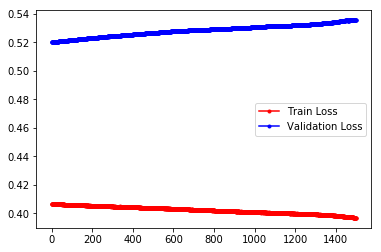

In [34]:
fig, ax = plt.subplots()
ax.plot(run_hist_student.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_student.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

# losses still going down but seems to settle at around 0.4. Value loss is however increasing

In [35]:
y_pred_class_nn_student = model_student.predict_classes(X_test_norm)
y_pred_prob_nn_student = model_student.predict(X_test_norm)

In [36]:
y_pred_class_nn_student # getting view of predicted classes

array([[1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
    

In [37]:
y_pred_prob_nn_student # getting view of predictions

array([[6.88251615e-01],
       [8.71926188e-01],
       [3.99446845e-01],
       [5.32833040e-02],
       [1.54084057e-01],
       [6.32225811e-01],
       [1.39907598e-02],
       [3.33203852e-01],
       [9.11061406e-01],
       [1.59324020e-01],
       [2.52628922e-02],
       [4.80701029e-02],
       [8.54541957e-01],
       [2.78702676e-02],
       [9.06107545e-01],
       [7.03934312e-01],
       [5.33368587e-01],
       [2.69754529e-01],
       [9.19829130e-01],
       [1.08952075e-01],
       [3.43965024e-01],
       [7.25075603e-03],
       [1.76487118e-01],
       [9.49058652e-01],
       [7.35970438e-01],
       [7.45358109e-01],
       [9.08178091e-01],
       [5.81291378e-01],
       [3.07652652e-02],
       [9.76920426e-01],
       [1.67991370e-01],
       [4.67354476e-01],
       [1.03168398e-01],
       [4.47079569e-01],
       [2.97543794e-01],
       [6.15961969e-01],
       [9.39427018e-01],
       [4.92034733e-01],
       [2.54709840e-01],
       [3.36990356e-01],


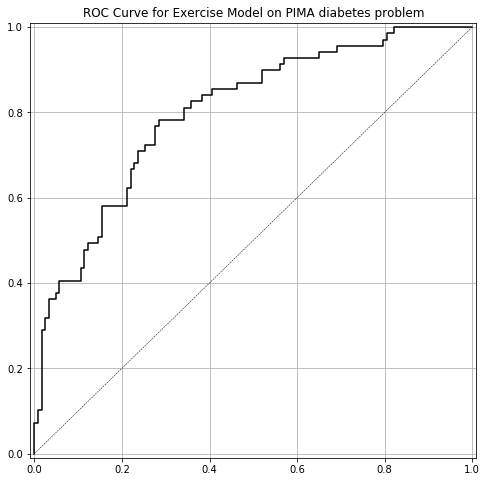

In [50]:
# Type your code here to plot the loss accuracy and ROC curve
plot_roc(y_test, y_pred_prob_nn_student, "Exercise Model") #plotting the ROC Curve

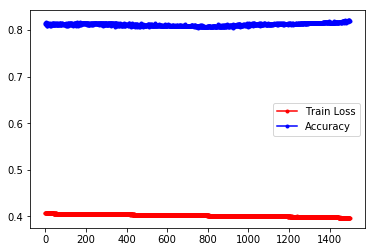

In [42]:
fig, ax = plt.subplots()
ax.plot(run_hist_student.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_student.history["accuracy"],'b', marker='.', label="Accuracy")
ax.legend()
# due to more hidden layers loss as settled at 0.4 and accuracy also settled at 0.8

In [43]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_student)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_student)))

accuracy is 0.750
roc-auc is 0.801
